<p><span style="font-size: 22pt;"><strong>Preprocess</strong></span></p><hr>
<p><span style="font-size: 11pt;">This file contains the dataset and the dataloader for LISA traffic sign dataset.</span></p>

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
class RoadSignDataset(Dataset):
    """
    LISA road sign dataset
    
    Each sample has three fields:
        - image: a matrix representing the image
        - tag: an integer representing the type of road sign
        - position: a 2*2 matrix representing
                [[left upper corner X , left upper corner Y],
                 [right lower corner X, right lower corner Y]]
                 
    Field:
        tag: the dictionary mapping types of road sign to integers
    """
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.lisa_frame = pd.read_csv(csv_file, sep=';').drop(
            columns = [
                'Occluded,On another road',
                'Origin file',
                'Origin frame number',
                'Origin track',
                'Origin track frame number'
            ]
        )
        tags = set()
        for i in range(len(self.lisa_frame)):
            tags.add(self.lisa_frame.iloc[i,1])
        self.tag_dict = dict(list(map(lambda x:(x[1],x[0]), list(enumerate(list(tags))))))
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.lisa_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.lisa_frame.iloc[idx, 0])
        image = io.imread(img_name)
        tag = self.tag_dict[self.lisa_frame.iloc[idx, 1]]
        position = self.lisa_frame.iloc[idx, 2:].as_matrix().astype('float').reshape(-1, 2)
        sample = {'image': image, 'tag': tag, 'position': position}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (522, 1024, 3) (2, 2)


<Figure size 432x288 with 0 Axes>

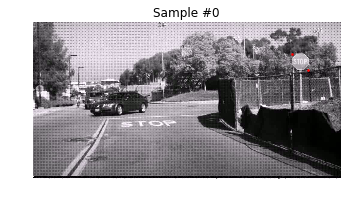

1 (522, 1024, 3) (2, 2)


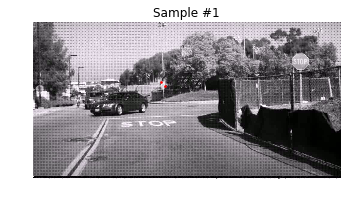

2 (522, 1024, 3) (2, 2)


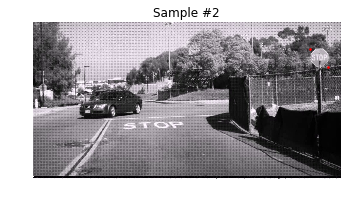

3 (522, 1024, 3) (2, 2)


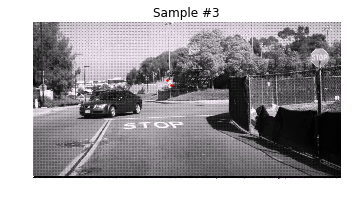

In [3]:
lisa_dataset = RoadSignDataset(csv_file='data/allAnnotations.csv',
                                    root_dir='data/')

fig = plt.figure()

def show_position(image, tag, position):
    """Show image with bounding boxes"""
    plt.imshow(image)
    plt.scatter(position[:, 0], position[:, 1], s=10, marker='.', c='r')
    plt.tight_layout()
    plt.pause(0.001)  # pause a bit so that plots are updated
    
for i in range(len(lisa_dataset)):
    sample = lisa_dataset[i]

    print(i, sample['image'].shape, sample['position'].shape)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.tight_layout()
    show_position(**sample)

    if i == 3:
        plt.show()
        break

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, tag, position = sample['image'], sample['tag'], sample['position']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for position because for images,
        # x and y axes are axis 1 and 0 respectively
        position = position * [new_w / w, new_h / h]

        return {'image': img, 'tag': tag, 'position': position}
    

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, tag, position = sample['image'], sample['tag'], sample['position']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'tag' : torch.tensor(tag),
                'position': torch.from_numpy(position)}

In [5]:
transformed_dataset = RoadSignDataset(csv_file='data/allAnnotations.csv',
                                           root_dir='data/',
                                           transform=transforms.Compose([
                                               Rescale((128,256)),
                                               ToTensor()
                                           ]))

<p><span style="font-size: 11pt;">Now, we create a dataloader.</span></p>

In [6]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

0 torch.Size([4, 3, 128, 256]) torch.Size([4, 2, 2])
1 torch.Size([4, 3, 128, 256]) torch.Size([4, 2, 2])
2 torch.Size([4, 3, 128, 256]) torch.Size([4, 2, 2])
3 torch.Size([4, 3, 128, 256]) torch.Size([4, 2, 2])


<Figure size 432x288 with 0 Axes>

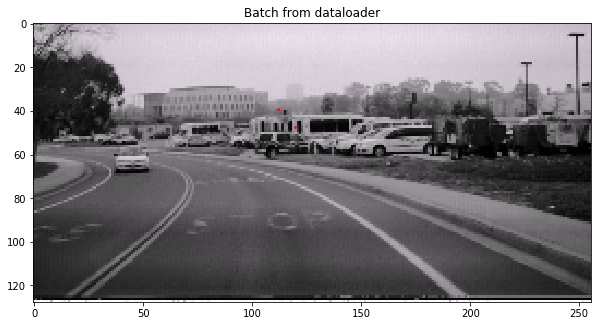

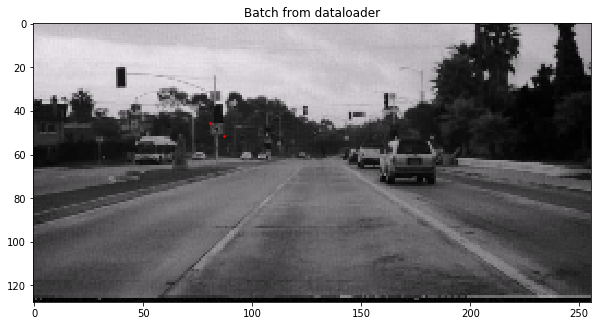

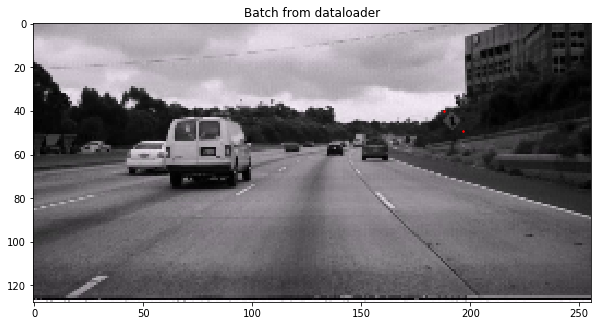

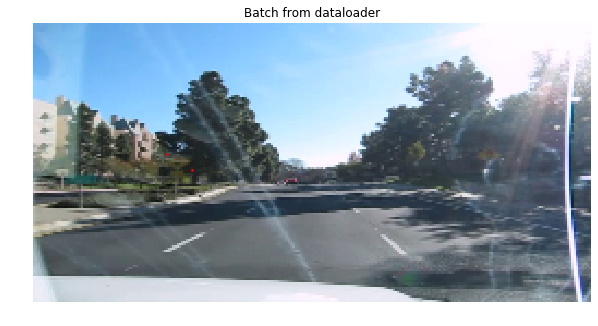

In [7]:
# Helper function to show a batch
def show_position_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, tag_batch, position_batch = \
            sample_batched['image'], sample_batched['tag'], sample_batched['position']
    batch_size = len(images_batch)

#     grid = utils.make_grid(images_batch)
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        fig, ax = plt.subplots(figsize=(10, 10))
        grid = utils.make_grid(images_batch[i])
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.scatter(position_batch[i, :, 0].numpy(),
                    position_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')
        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['position'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_position_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

<p><span style="font-size: 11pt;">Split the whole dataset into training set, validation set, and testing set in the ratio 7:1:2</span></p>

In [9]:
random_seed = 42
testing_split = .2
validation_split = .1
shuffle_dataset = True
batch_size = 4

# Creating data indices for training, validation, and testing splits:
dataset_size = len(transformed_dataset)
indices = list(range(dataset_size))
valid_split = int(np.floor(validation_split * dataset_size))
test_split = int(np.floor(testing_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices = indices[valid_split + test_split:]
val_indices = indices[:valid_split]
test_indices = indices[valid_split:valid_split + test_split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size,
                                          sampler=test_sampler)